<a href="https://colab.research.google.com/github/velasoka-repo/EVA4/blob/master/Session-10/EVA4_S10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Github Link](https://github.com/velasoka-repo/EVA4/tree/master/Session-10)

# Google Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#add working directory into syspath
EVA4_PATH = "/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-10"
import sys
if not EVA4_PATH in sys.path:
  sys.path.append(EVA4_PATH)

# Install Missing python Modules

In [0]:
pip install albumentations==0.4.5 #this version of model supports cutout with fill_value, else default `fill_value` is 0

In [0]:
pip install torch-lr-finder -v --global-option="amp"

# Python Module Import & device

In [5]:
import velasoka as vs
import velasoka_model as model
import velasoka_albumentations as al
import velasoka_gradcam as gr
import velasoka_lrfinder as lr
import velasoka_notebook as nb

device = vs.available_device()
device

  pip install torch-lr-finder -v --global-option="amp"


device(type='cuda')

# Download CIFAR10 data in Disk

In [0]:
train_data = vs.cifar10_dataset(transform=None, train=True) #albumentation uses downloaded CIFAR10 data to create Dataset

# View Augmentation Images
* Picked Random images from Training Dataset and applied Augmentation

In [0]:
nb.view_augmentation_images() # Colab not drawing the image using `plt`

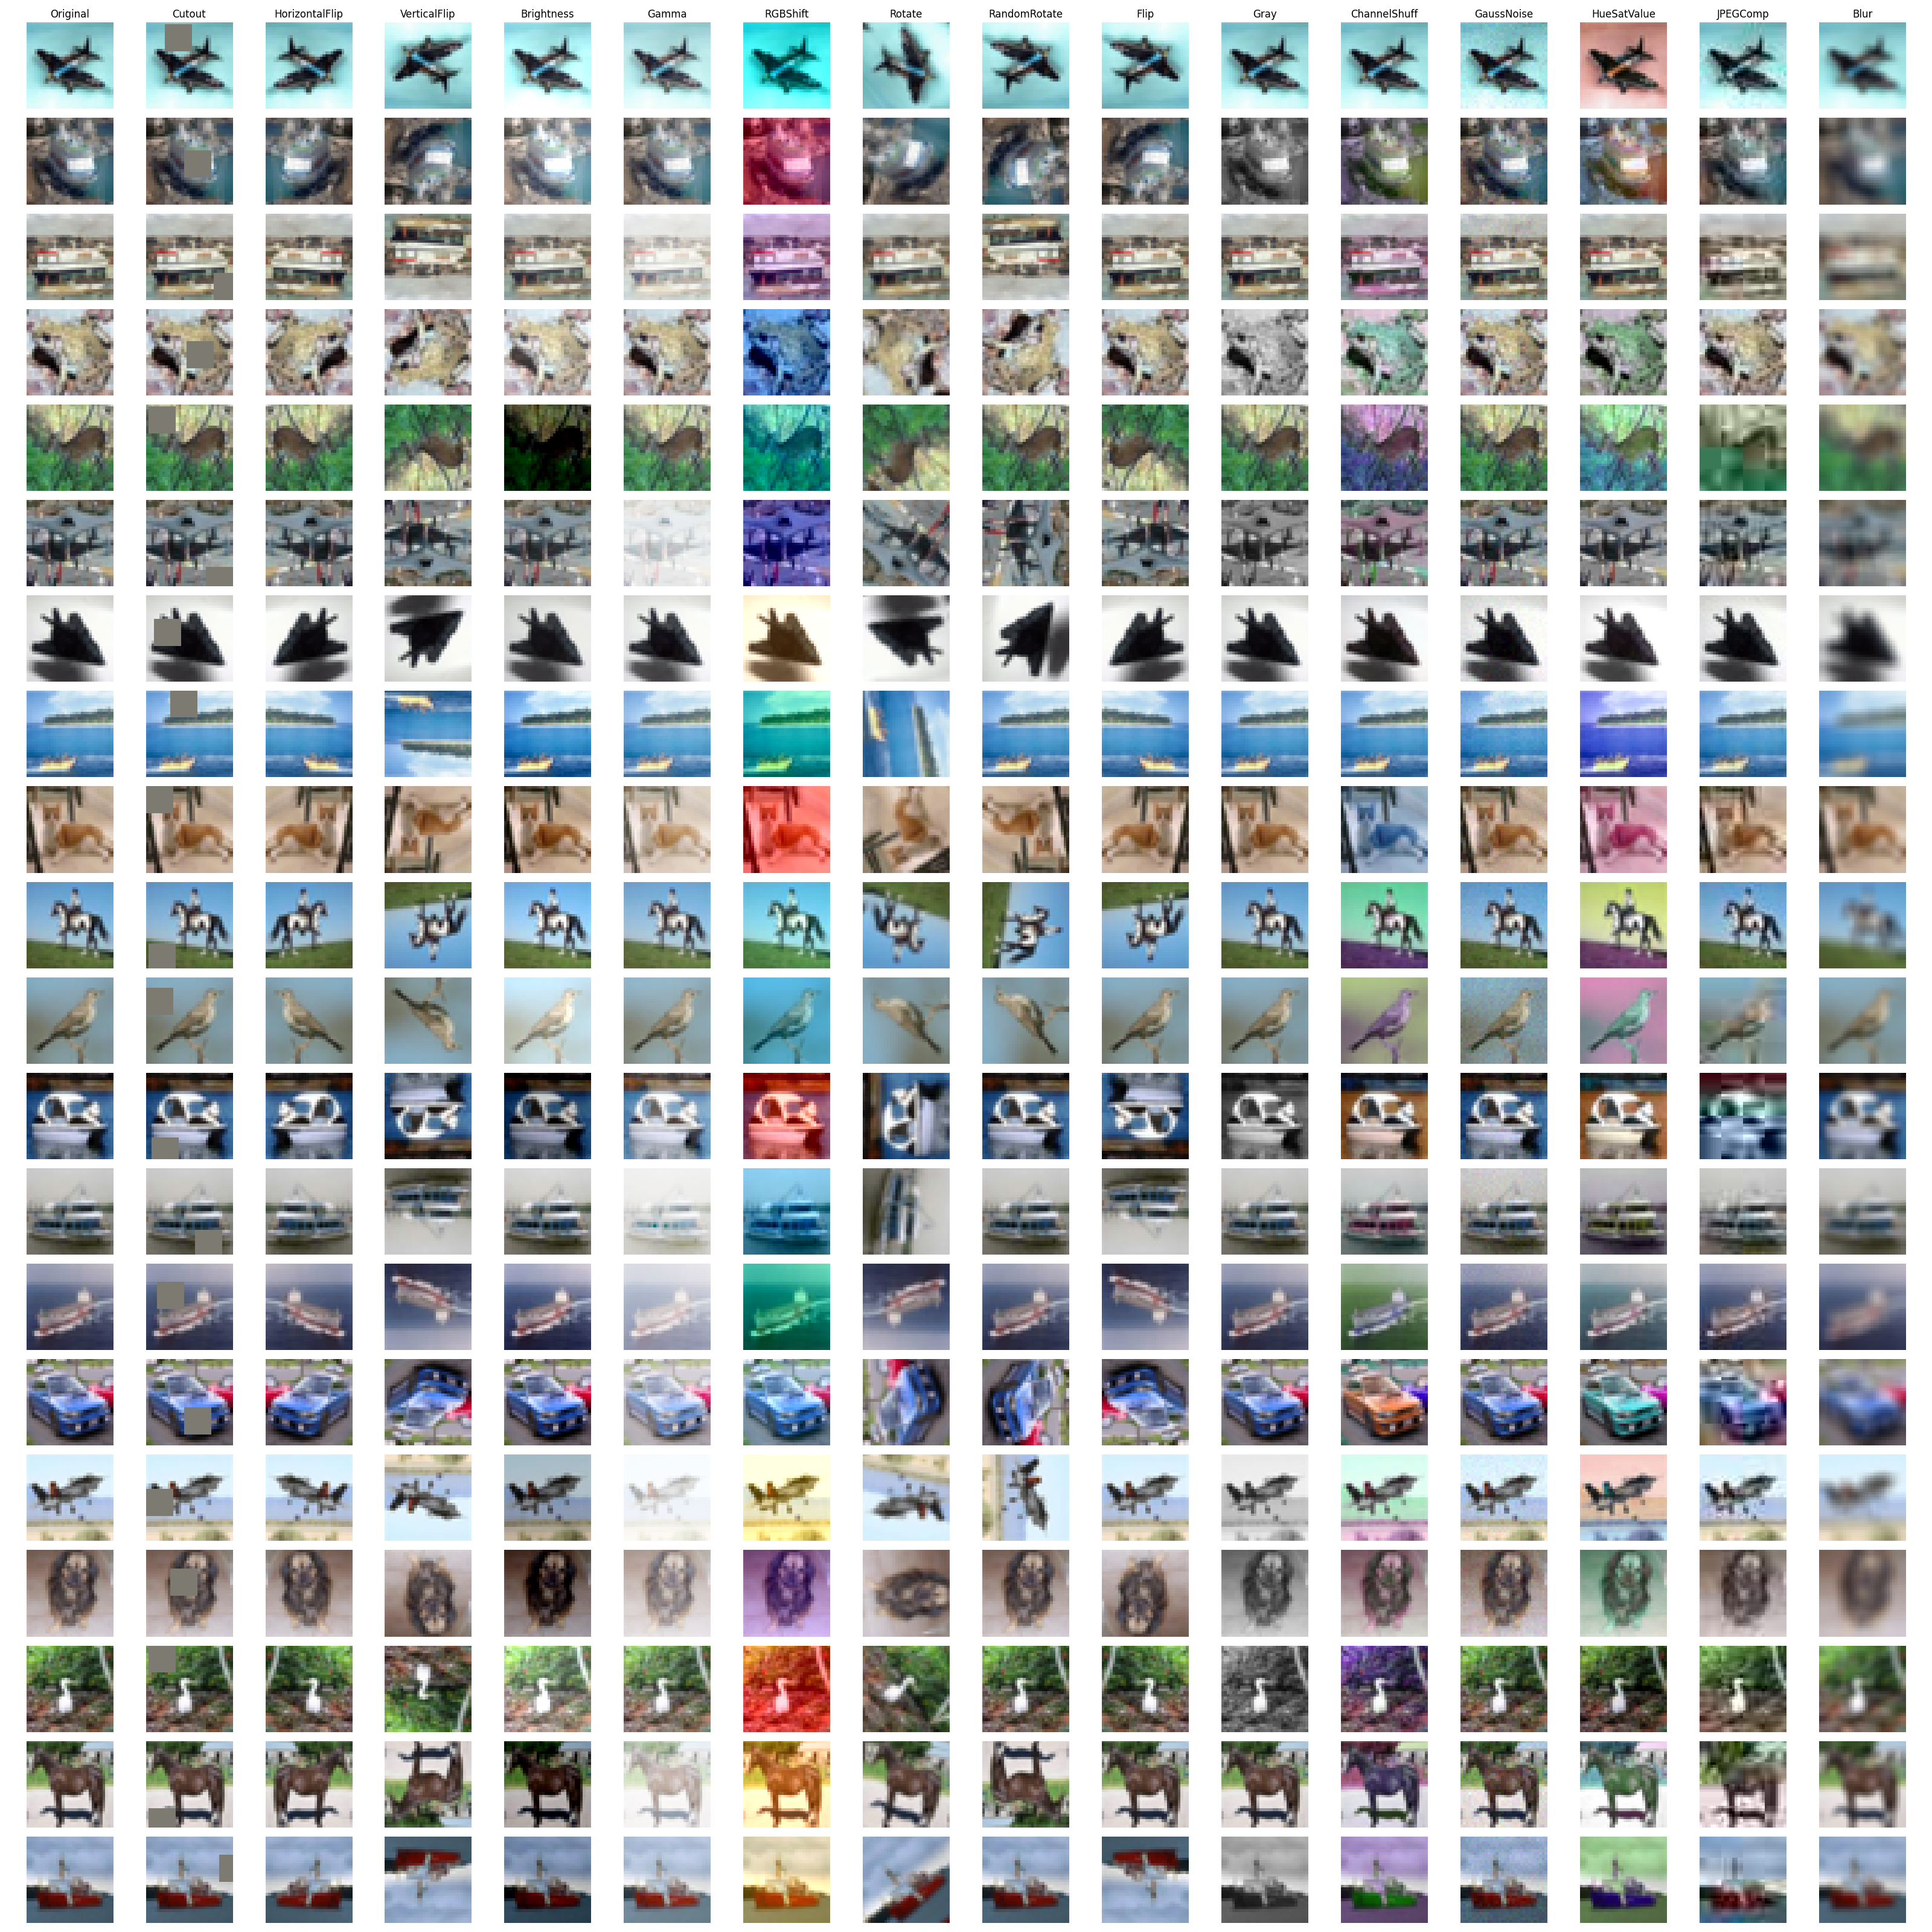

In [0]:
# above code takes long time so I have displayed my local testing augmentation images
from IPython.display import Image
filepath = vs.drive_path(filename="augmentation-images.png", folder="Session-10")
Image(filepath)

# LR Finder for ResNet18 Model
* As per the graph & history **Best Learning Rate** is **0.001258**, which is the one has minimun loss

Files already downloaded and verified
------------------------------------------------------------------------------------------------------------------------------------------------------
                                          Training Learning Rate Graph
------------------------------------------------------------------------------------------------------------------------------------------------------


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()



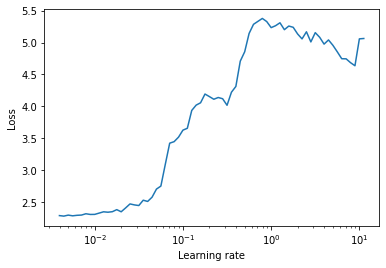

------------------------------------------------------------------------------------------------------------------------------------------------------
                                Training & Testing Learning Rate Graph
------------------------------------------------------------------------------------------------------------------------------------------------------


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


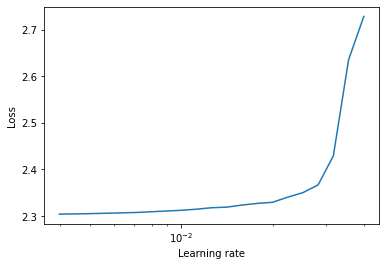

------------------------------------------------------------------------------------------------------------------------------------------------------
                                                 Learning Rate History
------------------------------------------------------------------------------------------------------------------------------------------------------
list of tried lr's
{'lr': [0.0012589254117941673, 0.0014125375446227544, 0.0015848931924611136, 0.0017782794100389228, 0.0019952623149688794, 0.00223872113856834, 0.0025118864315095803, 0.002818382931264454, 0.0031622776601683794, 0.0035481338923357545, 0.0039810717055349725, 0.004466835921509632, 0.005011872336272724, 0.00562341325190349, 0.006309573444801933, 0.00707945784384138, 0.007943282347242814, 0.008912509381337455, 0.010000000000000002, 0.011220184543019632, 0.012589254117941673, 0.014125375446227544, 0.015848931924611134, 0.01778279410038923, 0.0199526231496888, 0.022387211385683402, 0.025118864315095808, 0.0

In [0]:
nb.best_lr_finder()

* As per the graph & history **Best Learning Rate** is **0.001258**, which is the one has minimun loss

# GradCam Visualize

##### Get Cutout, HorizontalFlip Trained model
* Please find training details below besed on filename `resnet18-album-25.pt`

In [0]:
#this model is trained with cutout, horizontal flip, Please find training details below besed on filename
resnet18 = nb.trained_model(filename="resnet18-album-25.pt", folder="Session-10/trained-model/")
resnet18 = resnet18.to(device)

#get gradcam result for right & wrong predicted images
right_pred, wrong_pred = nb.gradcam_result(model=resnet18, count=30)

Files already downloaded and verified
Files already downloaded and verified


/content/gdrive/My Drive/Colab Notebooks/EVA4/Session-10/velasoka_gradcam.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = self.heatmap * torch.tensor(x)


### Show Wrongly Predicted Image

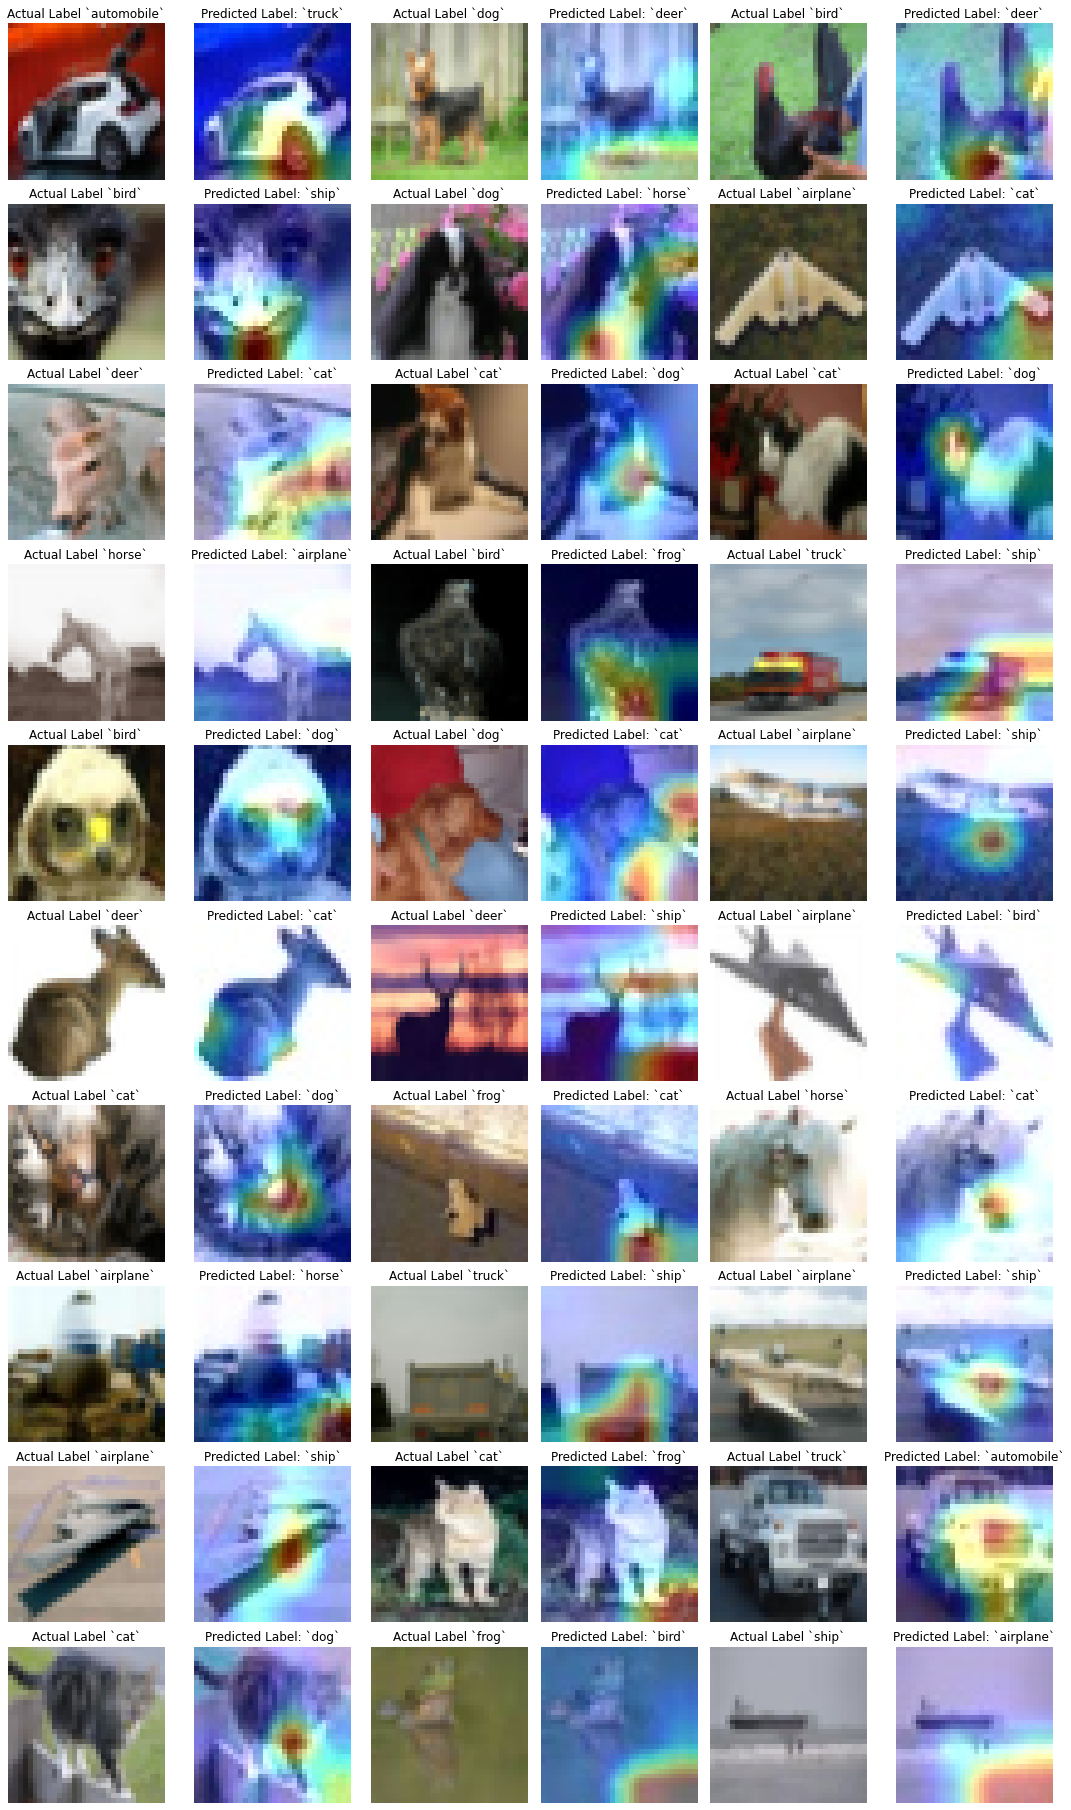

In [0]:
vs.show_images(data_list=wrong_pred, rows=10, columns=6)

### Show Rightly Predicted Image

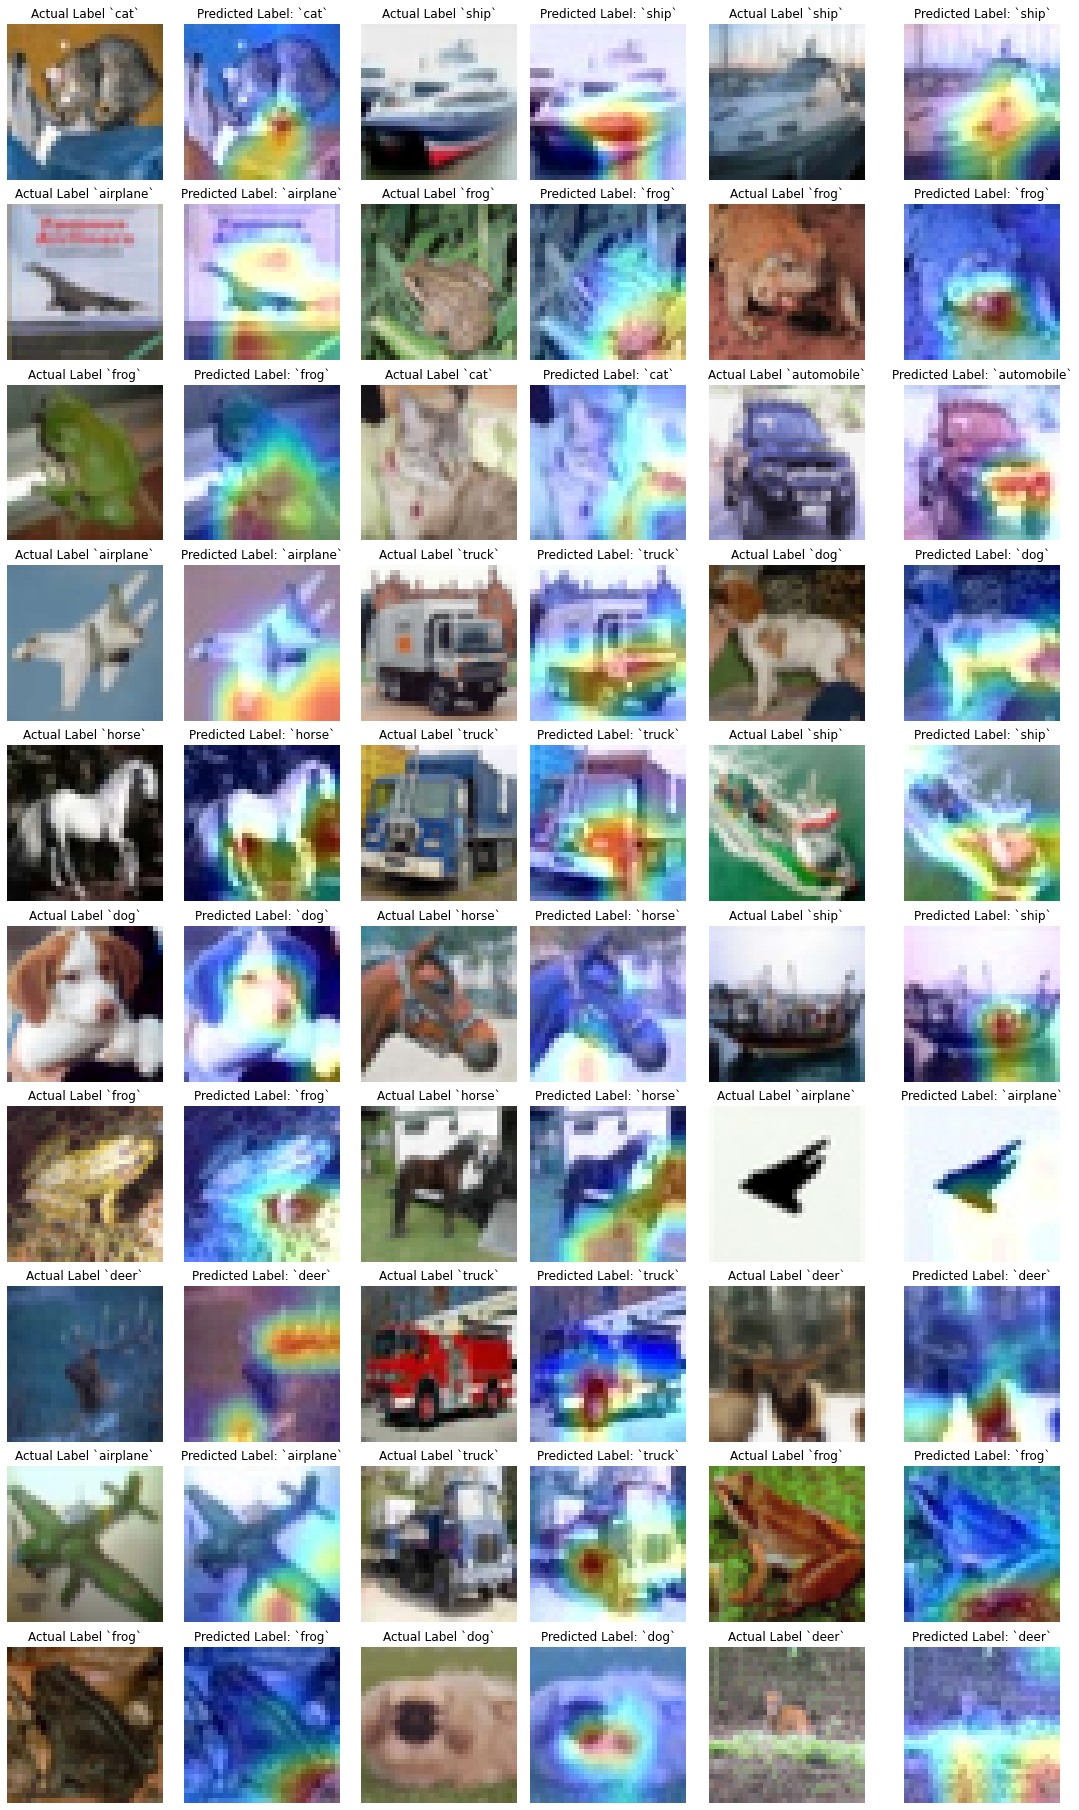

In [0]:
vs.show_images(data_list=right_pred, rows=10, columns=6)

# Train ResNet18 with `ReduceLROnPlateau`, using following `transform` dataset
1. Normal CIFAR10 train dataset (20 epochs)
2. Cutout CIFAR10 train dataset (15 epochs)
3. HorizontalFlip CIFAR10 train dataset (15 epochs)

### Prepare dataset, dataloader

In [7]:
#test dataset, dataloader
test_transform = vs.compose_transform(vs.to_tensor(), vs.to_normalize())
test_dataset = vs.cifar10_dataset(transform=test_transform, train=False)
test_dataloader = vs.cifar10_dataloader(dataset=test_dataset, batch_size=4)

data, labels = al.read_cifar10_train_data()

#normal train dataset, dataloader
normal_transform = al.compose(al.normalize(), al.tensor())
norm_train_dataset = al.Dataset(data=data, labels=labels, transform=normal_transform)
norm_train_dataloader = vs.cifar10_dataloader(dataset=norm_train_dataset, batch_size=4, shuffle=True)

#calculating mean & std to add cutout `fill_value`
mean, std = vs.mean_and_std(dataset=data)
cutout_trans = al.cutout(fill_value=mean, p=1)
cutout_train_dataset = al.transform_dataset(data, labels, cutout_trans, al.normalize(), al.tensor())
cutout_train_dataloader = vs.cifar10_dataloader(dataset=cutout_train_dataset, batch_size=4, shuffle=True)

#horizontal flip dataset, dataloader
hflip_train_dataset = al.transform_dataset(data, labels, al.hflip(p=0.8), al.normalize(), al.tensor())
hflip_train_dataloader = vs.cifar10_dataloader(dataset=cutout_train_dataset, batch_size=4, shuffle=True)

Files already downloaded and verified


#### epoch CNN run

In [0]:
def epoch_run(model, train_loader, test_loader, loss_fn, optimizer, device, dataset_name, epochs, scheduler):
  train_accuracy = []
  test_accuracy = []
  for epoch in range(1, epochs+1):
      print(f"\nEPCOH: {epoch} for {dataset_name}")
      train_accu = vs.train_cnn(model=model, data_loader=train_loader, loss_fn=loss_fn, optimizer=optimizer, device=device)
      train_accuracy.append(train_accu)
      
      filename = f"resnet18-train-{dataset_name}.pt"
      MODEL_SAVE_PATH = vs.drive_path(filename=filename, folder="Session-10/trained-model")
      vs.save_model(model=model, path=MODEL_SAVE_PATH)
      print(f"\n**********Trained {filename} file saved Successfully")

      test_accu = vs.test_cnn(model=model, data_loader=test_loader, device=device)
      test_accuracy.append(test_accu)

      scheduler.step(100-test_accu) #step to reduce lr, if accuracy is less than previous

  print("\n")
  print("-"*100)
  title = f"{dataset_name} Accuracy Graph"
  print(title.rjust(70, ' '))
  print("-"*100)
  print(f"Train Accuracy Change: {train_accuracy}")
  print(f"Test Accuracy Change: {test_accuracy}")

  vs.plot_accuracy_or_loss(points=train_accuracy, label=f"{dataset_name} Train Accuracy", xlabel="epochs", ylabel="Accuracy")
  vs.plot_accuracy_or_loss(points=test_accuracy, label=f"{dataset_name} Test Accuracy", xlabel="epochs", ylabel="Accuracy")

### Create Model, loss fn, optimizer & scheduler

In [0]:
resnet18 = model.ResNet18().to(device)
optimizer = vs.sgd_optimizer(model=resnet18, lr=0.001, momentum=0.9)
loss_fn = vs.ce_loss()
reduce_lr_scheduler = vs.reduce_lr_scheduler(optimizer=optimizer, min_lr=0.001)

### Train Model for `Normal` dataset `(20 epochs)`

  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 1 for Normal-Dataset


Training Batch=12499, loss=0.35578, Correct Prediction=26600/50000, Train Accuracy=53.20000: 100%|██████████| 12500/12500 [03:35<00:00, 58.05it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=7032/10000, Test Accuracy=70.32000: 100%|██████████| 2500/2500 [00:21<00:00, 117.28it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 2 for Normal-Dataset


Training Batch=12499, loss=0.59238, Correct Prediction=36804/50000, Train Accuracy=73.60800: 100%|██████████| 12500/12500 [03:34<00:00, 58.15it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=7619/10000, Test Accuracy=76.19000: 100%|██████████| 2500/2500 [00:22<00:00, 109.90it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 3 for Normal-Dataset


Training Batch=12499, loss=0.75689, Correct Prediction=40272/50000, Train Accuracy=80.54400: 100%|██████████| 12500/12500 [03:37<00:00, 57.43it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8051/10000, Test Accuracy=80.51000: 100%|██████████| 2500/2500 [00:22<00:00, 112.94it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 4 for Normal-Dataset


Training Batch=12499, loss=0.39205, Correct Prediction=42797/50000, Train Accuracy=85.59400: 100%|██████████| 12500/12500 [03:36<00:00, 57.74it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8228/10000, Test Accuracy=82.28000: 100%|██████████| 2500/2500 [00:22<00:00, 111.77it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 5 for Normal-Dataset


Training Batch=12499, loss=0.00203, Correct Prediction=44651/50000, Train Accuracy=89.30200: 100%|██████████| 12500/12500 [03:37<00:00, 57.56it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8169/10000, Test Accuracy=81.69000: 100%|██████████| 2500/2500 [00:22<00:00, 111.53it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 6 for Normal-Dataset


Training Batch=12499, loss=0.00376, Correct Prediction=46376/50000, Train Accuracy=92.75200: 100%|██████████| 12500/12500 [03:39<00:00, 57.06it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8267/10000, Test Accuracy=82.67000: 100%|██████████| 2500/2500 [00:22<00:00, 109.68it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 7 for Normal-Dataset


Training Batch=12499, loss=0.33625, Correct Prediction=47587/50000, Train Accuracy=95.17400: 100%|██████████| 12500/12500 [03:39<00:00, 56.99it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8251/10000, Test Accuracy=82.51000: 100%|██████████| 2500/2500 [00:22<00:00, 113.06it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 8 for Normal-Dataset


Training Batch=12499, loss=0.01026, Correct Prediction=48656/50000, Train Accuracy=97.31200: 100%|██████████| 12500/12500 [03:36<00:00, 57.66it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8410/10000, Test Accuracy=84.10000: 100%|██████████| 2500/2500 [00:22<00:00, 113.43it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 9 for Normal-Dataset


Training Batch=12499, loss=0.16831, Correct Prediction=49393/50000, Train Accuracy=98.78600: 100%|██████████| 12500/12500 [03:36<00:00, 57.74it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8444/10000, Test Accuracy=84.44000: 100%|██████████| 2500/2500 [00:21<00:00, 114.82it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 10 for Normal-Dataset


Training Batch=12499, loss=0.00041, Correct Prediction=49608/50000, Train Accuracy=99.21600: 100%|██████████| 12500/12500 [03:36<00:00, 57.78it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8380/10000, Test Accuracy=83.80000: 100%|██████████| 2500/2500 [00:22<00:00, 113.21it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 11 for Normal-Dataset


Training Batch=12499, loss=0.00013, Correct Prediction=49857/50000, Train Accuracy=99.71400: 100%|██████████| 12500/12500 [03:35<00:00, 57.96it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8506/10000, Test Accuracy=85.06000: 100%|██████████| 2500/2500 [00:21<00:00, 116.11it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 12 for Normal-Dataset


Training Batch=12499, loss=0.00476, Correct Prediction=49945/50000, Train Accuracy=99.89000: 100%|██████████| 12500/12500 [03:36<00:00, 57.86it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8566/10000, Test Accuracy=85.66000: 100%|██████████| 2500/2500 [00:21<00:00, 113.98it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 13 for Normal-Dataset


Training Batch=12499, loss=0.49594, Correct Prediction=49965/50000, Train Accuracy=99.93000: 100%|██████████| 12500/12500 [03:36<00:00, 57.68it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8530/10000, Test Accuracy=85.30000: 100%|██████████| 2500/2500 [00:22<00:00, 109.95it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 14 for Normal-Dataset


Training Batch=12499, loss=0.00021, Correct Prediction=49995/50000, Train Accuracy=99.99000: 100%|██████████| 12500/12500 [03:41<00:00, 56.49it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8603/10000, Test Accuracy=86.03000: 100%|██████████| 2500/2500 [00:21<00:00, 114.40it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 15 for Normal-Dataset


Training Batch=12499, loss=0.00263, Correct Prediction=49992/50000, Train Accuracy=99.98400: 100%|██████████| 12500/12500 [03:36<00:00, 57.77it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8620/10000, Test Accuracy=86.20000: 100%|██████████| 2500/2500 [00:21<00:00, 114.17it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 16 for Normal-Dataset


Training Batch=12499, loss=0.00000, Correct Prediction=49995/50000, Train Accuracy=99.99000: 100%|██████████| 12500/12500 [03:34<00:00, 58.32it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8610/10000, Test Accuracy=86.10000: 100%|██████████| 2500/2500 [00:21<00:00, 115.97it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 17 for Normal-Dataset


Training Batch=12499, loss=0.00027, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:35<00:00, 58.13it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8644/10000, Test Accuracy=86.44000: 100%|██████████| 2500/2500 [00:21<00:00, 116.55it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 18 for Normal-Dataset


Training Batch=12499, loss=0.00016, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.58it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8628/10000, Test Accuracy=86.28000: 100%|██████████| 2500/2500 [00:22<00:00, 113.38it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 19 for Normal-Dataset


Training Batch=12499, loss=0.09024, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.33it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8637/10000, Test Accuracy=86.37000: 100%|██████████| 2500/2500 [00:21<00:00, 115.35it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 20 for Normal-Dataset


Training Batch=12499, loss=0.00033, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:35<00:00, 58.14it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Normal-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8639/10000, Test Accuracy=86.39000: 100%|██████████| 2500/2500 [00:21<00:00, 115.21it/s]




----------------------------------------------------------------------------------------------------
                                         Normal-Dataset Accuracy Graph
----------------------------------------------------------------------------------------------------
Train Accuracy Change: [53.2, 73.608, 80.544, 85.594, 89.302, 92.752, 95.174, 97.312, 98.786, 99.216, 99.714, 99.89, 99.93, 99.99, 99.984, 99.99, 99.998, 100.0, 100.0, 100.0]
Test Accuracy Change: [70.32, 76.19, 80.51, 82.28, 81.69, 82.67, 82.51, 84.1, 84.44, 83.8, 85.06, 85.66, 85.3, 86.03, 86.2, 86.1, 86.44, 86.28, 86.37, 86.39]


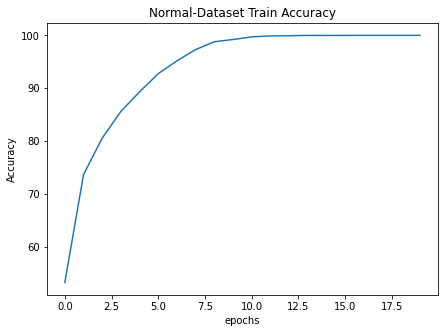

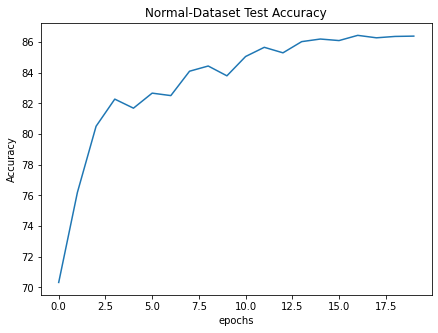

In [0]:
# normal dataset
epoch_run(model=resnet18, 
          train_loader=norm_train_dataloader, 
          test_loader=test_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optimizer, 
          device=device, 
          dataset_name="Normal-Dataset", 
          epochs=20,
          scheduler=reduce_lr_scheduler)

### Train model for `Cutout` dataset `(15 epochs)`

  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 1 for Cutout-Dataset


Training Batch=12499, loss=0.02181, Correct Prediction=44572/50000, Train Accuracy=89.14400: 100%|██████████| 12500/12500 [03:38<00:00, 57.32it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8337/10000, Test Accuracy=83.37000: 100%|██████████| 2500/2500 [00:22<00:00, 111.00it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 2 for Cutout-Dataset


Training Batch=12499, loss=0.29833, Correct Prediction=48289/50000, Train Accuracy=96.57800: 100%|██████████| 12500/12500 [03:35<00:00, 58.09it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8280/10000, Test Accuracy=82.80000: 100%|██████████| 2500/2500 [00:21<00:00, 116.61it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 3 for Cutout-Dataset


Training Batch=12499, loss=0.00522, Correct Prediction=49220/50000, Train Accuracy=98.44000: 100%|██████████| 12500/12500 [03:34<00:00, 58.28it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8441/10000, Test Accuracy=84.41000: 100%|██████████| 2500/2500 [00:21<00:00, 116.74it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 4 for Cutout-Dataset


Training Batch=12499, loss=0.02566, Correct Prediction=49705/50000, Train Accuracy=99.41000: 100%|██████████| 12500/12500 [03:34<00:00, 58.30it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8545/10000, Test Accuracy=85.45000: 100%|██████████| 2500/2500 [00:21<00:00, 114.62it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 5 for Cutout-Dataset


Training Batch=12499, loss=0.00012, Correct Prediction=49915/50000, Train Accuracy=99.83000: 100%|██████████| 12500/12500 [03:34<00:00, 58.38it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8622/10000, Test Accuracy=86.22000: 100%|██████████| 2500/2500 [00:21<00:00, 117.15it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 6 for Cutout-Dataset


Training Batch=12499, loss=0.00276, Correct Prediction=49972/50000, Train Accuracy=99.94400: 100%|██████████| 12500/12500 [03:33<00:00, 58.63it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8664/10000, Test Accuracy=86.64000: 100%|██████████| 2500/2500 [00:21<00:00, 117.40it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 7 for Cutout-Dataset


Training Batch=12499, loss=0.00236, Correct Prediction=49981/50000, Train Accuracy=99.96200: 100%|██████████| 12500/12500 [03:33<00:00, 58.59it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8685/10000, Test Accuracy=86.85000: 100%|██████████| 2500/2500 [00:21<00:00, 117.27it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 8 for Cutout-Dataset


Training Batch=12499, loss=0.00118, Correct Prediction=49994/50000, Train Accuracy=99.98800: 100%|██████████| 12500/12500 [03:35<00:00, 58.06it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8678/10000, Test Accuracy=86.78000: 100%|██████████| 2500/2500 [00:21<00:00, 113.78it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 9 for Cutout-Dataset


Training Batch=12499, loss=0.00014, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:36<00:00, 57.82it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8699/10000, Test Accuracy=86.99000: 100%|██████████| 2500/2500 [00:21<00:00, 113.98it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 10 for Cutout-Dataset


Training Batch=12499, loss=0.00015, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.36it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8717/10000, Test Accuracy=87.17000: 100%|██████████| 2500/2500 [00:21<00:00, 116.04it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 11 for Cutout-Dataset


Training Batch=12499, loss=0.00019, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.46it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8692/10000, Test Accuracy=86.92000: 100%|██████████| 2500/2500 [00:21<00:00, 116.34it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 12 for Cutout-Dataset


Training Batch=12499, loss=0.00148, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.48it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8698/10000, Test Accuracy=86.98000: 100%|██████████| 2500/2500 [00:21<00:00, 115.34it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 13 for Cutout-Dataset


Training Batch=12499, loss=0.00194, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:34<00:00, 58.16it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8702/10000, Test Accuracy=87.02000: 100%|██████████| 2500/2500 [00:21<00:00, 113.88it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 14 for Cutout-Dataset


Training Batch=12499, loss=0.00005, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:35<00:00, 57.95it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8711/10000, Test Accuracy=87.11000: 100%|██████████| 2500/2500 [00:21<00:00, 114.86it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 15 for Cutout-Dataset


Training Batch=12499, loss=0.00031, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:35<00:00, 58.01it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-Cutout-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8708/10000, Test Accuracy=87.08000: 100%|██████████| 2500/2500 [00:21<00:00, 114.89it/s]




----------------------------------------------------------------------------------------------------
                                         Cutout-Dataset Accuracy Graph
----------------------------------------------------------------------------------------------------
Train Accuracy Change: [89.144, 96.578, 98.44, 99.41, 99.83, 99.944, 99.962, 99.988, 99.994, 100.0, 100.0, 100.0, 99.998, 99.996, 99.998]
Test Accuracy Change: [83.37, 82.8, 84.41, 85.45, 86.22, 86.64, 86.85, 86.78, 86.99, 87.17, 86.92, 86.98, 87.02, 87.11, 87.08]


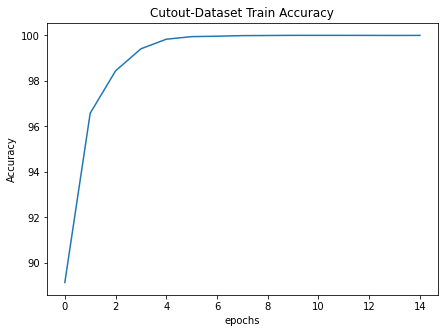

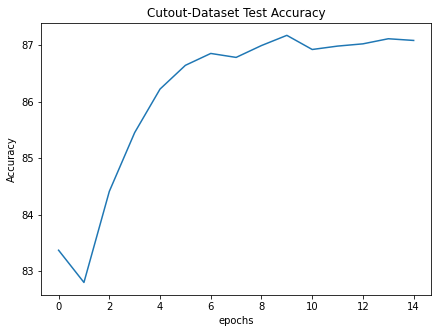

In [0]:
# Cutout dataset
epoch_run(model=resnet18, 
          train_loader=cutout_train_dataloader, 
          test_loader=test_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optimizer, 
          device=device, 
          dataset_name="Cutout-Dataset", 
          epochs=15,
          scheduler=reduce_lr_scheduler)

### Train model for `HorizontalFlip` dataset `(15 epochs)`

  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 1 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00077, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:36<00:00, 57.81it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8724/10000, Test Accuracy=87.24000: 100%|██████████| 2500/2500 [00:21<00:00, 116.43it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 2 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00022, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:35<00:00, 58.11it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8711/10000, Test Accuracy=87.11000: 100%|██████████| 2500/2500 [00:21<00:00, 116.81it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 3 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00005, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.30it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8714/10000, Test Accuracy=87.14000: 100%|██████████| 2500/2500 [00:21<00:00, 114.27it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 4 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00000, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.48it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8726/10000, Test Accuracy=87.26000: 100%|██████████| 2500/2500 [00:21<00:00, 118.92it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 5 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00001, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:33<00:00, 58.62it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8704/10000, Test Accuracy=87.04000: 100%|██████████| 2500/2500 [00:21<00:00, 116.03it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 6 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00004, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.51it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8709/10000, Test Accuracy=87.09000: 100%|██████████| 2500/2500 [00:21<00:00, 114.84it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 7 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00039, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:36<00:00, 57.84it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8709/10000, Test Accuracy=87.09000: 100%|██████████| 2500/2500 [00:21<00:00, 114.66it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 8 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00038, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.35it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8709/10000, Test Accuracy=87.09000: 100%|██████████| 2500/2500 [00:21<00:00, 117.66it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 9 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00004, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:30<00:00, 59.24it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8706/10000, Test Accuracy=87.06000: 100%|██████████| 2500/2500 [00:20<00:00, 119.86it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 10 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00023, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:29<00:00, 59.66it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8697/10000, Test Accuracy=86.97000: 100%|██████████| 2500/2500 [00:21<00:00, 118.47it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 11 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00005, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:30<00:00, 59.29it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8699/10000, Test Accuracy=86.99000: 100%|██████████| 2500/2500 [00:20<00:00, 119.97it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 12 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00014, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:30<00:00, 59.45it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8720/10000, Test Accuracy=87.20000: 100%|██████████| 2500/2500 [00:21<00:00, 119.01it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 13 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00056, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.32it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8696/10000, Test Accuracy=86.96000: 100%|██████████| 2500/2500 [00:22<00:00, 112.88it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 14 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00007, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:40<00:00, 56.65it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8726/10000, Test Accuracy=87.26000: 100%|██████████| 2500/2500 [00:23<00:00, 107.94it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]


EPCOH: 15 for HorizontalFlip-Dataset


Training Batch=12499, loss=0.00007, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:47<00:00, 55.03it/s]
  0%|          | 0/2500 [00:00<?, ?it/s]


**********Trained resnet18-train-HorizontalFlip-Dataset.pt file saved Successfully


Test Batch=2499, Correct Validation=8733/10000, Test Accuracy=87.33000: 100%|██████████| 2500/2500 [00:22<00:00, 112.85it/s]




----------------------------------------------------------------------------------------------------
                                 HorizontalFlip-Dataset Accuracy Graph
----------------------------------------------------------------------------------------------------
Train Accuracy Change: [100.0, 100.0, 100.0, 100.0, 99.996, 100.0, 100.0, 100.0, 99.998, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Test Accuracy Change: [87.24, 87.11, 87.14, 87.26, 87.04, 87.09, 87.09, 87.09, 87.06, 86.97, 86.99, 87.2, 86.96, 87.26, 87.33]


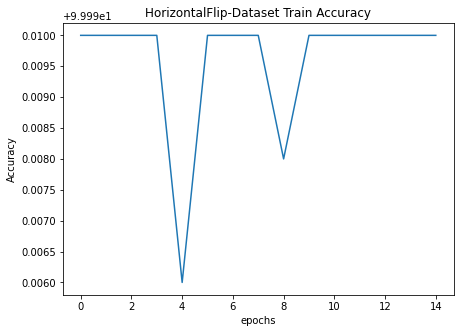

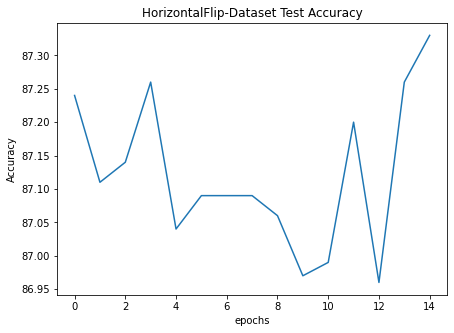

In [0]:
# HorizontalFlip dataset
epoch_run(model=resnet18, 
          train_loader=hflip_train_dataloader, 
          test_loader=test_dataloader, 
          loss_fn=loss_fn, 
          optimizer=optimizer, 
          device=device, 
          dataset_name="HorizontalFlip-Dataset", 
          epochs=15,
          scheduler=reduce_lr_scheduler)


---



# - - - - - - TRIED `EXTRA IMAGE AUGMENTATION` MODEL TRAINING & VALIDATION - - - - - -

# Restore Existing Model

In [0]:
# restore trained model
resnet18 = model.ResNet18().to(device)
stat_dict = velasoka.load_model(MODEL_PATH) 
resnet18.load_state_dict(stat_dict)

<All keys matched successfully>

# Download CIFAR10 data

In [0]:
# make CIFAR10 data available in disk so that albumentation can read data from directory 
train_data = velasoka.cifar10_dataset(transform=None, train=True)

# Optimizer, loss, Model Summary, load CIFAR10 class labels, data from disk

In [0]:
# read CIFAR10 class labels from metadata
CIFAR10_LABELS = al.cifar10_class_names() 
print(f"CIFAR10 CLASS LABELS: {CIFAR10_LABELS}")

# optimizer, loss
optimizer = velasoka.sgd_optimizer(resnet18)
loss = velasoka.ce_loss()

# model summary
# velasoka.model_summary(model=resnet18, input_size=(3, 32, 32), device=device)

data, labels = al.read_cifar10_train_data()

CIFAR10 CLASS LABELS: ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# Train & Save ResNet18 Model

In [0]:
  def save_model_accuracy(itr_count, transform):
    #save model
    filename = f"resnet18-album-{itr_count}.pt"
    drive_file_path = velasoka.drive_path(folder="Session-10/trained-model/", filename=filename)
    velasoka.save_model(model=resnet18, path=drive_file_path)
    velasoka.save_last_run(itr_count, RUN_ID_PATH)
    print(f"{transform} Saved Successfully: {filename}")

In [0]:
def train_al_transform(trans, epoch, itr_count):
  # albumentation transforms hflip, normalize, tensor
  dataset = al.albumentation_dataset(data, labels, trans, al.normalize(), al.tensor())
  data_loader = velasoka.cifar10_dataloader(dataset=dataset, shuffle=True)

  for i in range(1, epoch):

    print(f"EPOCH: {i} running {trans}")
    accuracy = velasoka.train_cnn(model=resnet18, data_loader=data_loader, optimizer=optimizer, loss_fn=loss, device=device)
    
    if float(accuracy) == 100:
      break
    
    save_model_accuracy(itr_count=itr_count, transform=trans)
    velasoka.save_last_run(run_id=itr_count, path=RUN_ID_PATH)

# Albumentations Transforms Training
* Storing model for each augmentation, because colab is disconneting very often
* transform_list = [(transform_function, no. of epochs)......]

In [0]:
# calculate mean of train dataset, so that cutout value uses this mean to add fill_value
mean, std = vs.mean_and_std(train_data.data)

#max i kept 10 epoch, if training reaches 100% accuracy before 10 epoch it breaks the epochs loop
transforms_list = [(al.cutout(fill_value=mean, p=1), 15),
                      (al.hflip(p=1), 10),
                      (al.vflip(p=1), 10), #-ve reduces Test Accuracy
                      (al.random_brightness(p=1, brightness=0.3, contrast=0.2), 10),
                      (al.randomgamma(p=1, gamma=(10, 100)), 10),
                      (al.rgb_shift(p=1), 10),
                      (al.rotate(p=1), 10),
                      (al.random_rotate90(p=0.6), 10),
                      (al.flip(), 10),
                      # (al.gray(), 10), # ignored because, if you see above augmentation image, I don't see this transform is applied
                      # (al.channel_shuffle(p=1), 10), #ignored because (can't write generic code), this transformation uses channels_shuffle=[0, 1, 2] when we call this method
                      (al.gaussnoise(p=1), 10),
                      (al.hue_satur_value(p=1), 10),
                      (al.compression(p=1), 10),
                      (al.blur(p=1), 10)] #-ve this reduces Test Accuracy

# Augmentation Dataset Run for Training Model

In [0]:
for (fn, epoch) in transforms_list:
  # print(f, epoch)
  train_al_transform(trans=fn, epoch=epoch, itr_count=run_id)
  save_model_accuracy(itr_count=run_id, transform=fn)
  velasoka.save_last_run(run_id=run_id, path=RUN_ID_PATH)
  run_id += 1

  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00177, Correct Prediction=49492/50000, Train Accuracy=98.98400: 100%|██████████| 12500/12500 [03:21<00:00, 62.17it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt
EPOCH: 2 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00002, Correct Prediction=49880/50000, Train Accuracy=99.76000: 100%|██████████| 12500/12500 [03:21<00:00, 62.16it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00008, Correct Prediction=49978/50000, Train Accuracy=99.95600: 100%|██████████| 12500/12500 [03:21<00:00, 62.12it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00052, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:20<00:00, 62.46it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00001, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:23<00:00, 61.55it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00006, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:20<00:00, 62.44it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00105, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:20<00:00, 62.27it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00000, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:20<00:00, 62.27it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10)


Training Batch=12499, loss=0.00000, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:21<00:00, 62.05it/s]


Cutout(always_apply=False, p=1, num_holes=1, max_h_size=10, max_w_size=10) Saved Successfully: resnet18-album-24.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.32021, Correct Prediction=48601/50000, Train Accuracy=97.20200: 100%|██████████| 12500/12500 [03:21<00:00, 61.98it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt
EPOCH: 2 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.03452, Correct Prediction=49671/50000, Train Accuracy=99.34200: 100%|██████████| 12500/12500 [03:20<00:00, 62.25it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00001, Correct Prediction=49923/50000, Train Accuracy=99.84600: 100%|██████████| 12500/12500 [03:20<00:00, 62.25it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00463, Correct Prediction=49968/50000, Train Accuracy=99.93600: 100%|██████████| 12500/12500 [03:21<00:00, 61.96it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00002, Correct Prediction=49984/50000, Train Accuracy=99.96800: 100%|██████████| 12500/12500 [03:22<00:00, 61.78it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00126, Correct Prediction=49996/50000, Train Accuracy=99.99200: 100%|██████████| 12500/12500 [03:21<00:00, 62.00it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00124, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:21<00:00, 62.13it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running HorizontalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00000, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:20<00:00, 62.39it/s]


HorizontalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-25.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=1.50246, Correct Prediction=43260/50000, Train Accuracy=86.52000: 100%|██████████| 12500/12500 [03:20<00:00, 62.33it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt
EPOCH: 2 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.04862, Correct Prediction=48586/50000, Train Accuracy=97.17200: 100%|██████████| 12500/12500 [03:20<00:00, 62.39it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00139, Correct Prediction=49689/50000, Train Accuracy=99.37800: 100%|██████████| 12500/12500 [03:19<00:00, 62.62it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00837, Correct Prediction=49916/50000, Train Accuracy=99.83200: 100%|██████████| 12500/12500 [03:20<00:00, 62.34it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt
EPOCH: 5 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00036, Correct Prediction=49968/50000, Train Accuracy=99.93600: 100%|██████████| 12500/12500 [03:22<00:00, 61.64it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00053, Correct Prediction=49979/50000, Train Accuracy=99.95800: 100%|██████████| 12500/12500 [03:21<00:00, 61.95it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00043, Correct Prediction=49989/50000, Train Accuracy=99.97800: 100%|██████████| 12500/12500 [03:19<00:00, 62.53it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00154, Correct Prediction=49990/50000, Train Accuracy=99.98000: 100%|██████████| 12500/12500 [03:19<00:00, 62.54it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running VerticalFlip(always_apply=False, p=1)


Training Batch=12499, loss=0.00114, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:20<00:00, 62.44it/s]


VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt
VerticalFlip(always_apply=False, p=1) Saved Successfully: resnet18-album-26.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00144, Correct Prediction=49474/50000, Train Accuracy=98.94800: 100%|██████████| 12500/12500 [03:20<00:00, 62.35it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt
EPOCH: 2 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00819, Correct Prediction=49950/50000, Train Accuracy=99.90000: 100%|██████████| 12500/12500 [03:20<00:00, 62.26it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00024, Correct Prediction=49991/50000, Train Accuracy=99.98200: 100%|██████████| 12500/12500 [03:19<00:00, 62.50it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00018, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:20<00:00, 62.36it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00001, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:21<00:00, 61.94it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00010, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:21<00:00, 61.88it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True)


Training Batch=12499, loss=0.00008, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:20<00:00, 62.33it/s]


RandomBrightnessContrast(always_apply=False, p=1, brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), brightness_by_max=True) Saved Successfully: resnet18-album-27.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.01566, Correct Prediction=49847/50000, Train Accuracy=99.69400: 100%|██████████| 12500/12500 [03:19<00:00, 62.60it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt
EPOCH: 2 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00001, Correct Prediction=49982/50000, Train Accuracy=99.96400: 100%|██████████| 12500/12500 [03:18<00:00, 62.84it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00218, Correct Prediction=49989/50000, Train Accuracy=99.97800: 100%|██████████| 12500/12500 [03:19<00:00, 62.62it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00006, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:19<00:00, 62.75it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00010, Correct Prediction=49996/50000, Train Accuracy=99.99200: 100%|██████████| 12500/12500 [03:20<00:00, 62.43it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00001, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:19<00:00, 62.62it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None)


Training Batch=12499, loss=0.00004, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:21<00:00, 62.13it/s]


RandomGamma(always_apply=False, p=1, gamma_limit=(10, 100), eps=None) Saved Successfully: resnet18-album-28.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40))


Training Batch=12499, loss=0.00188, Correct Prediction=49914/50000, Train Accuracy=99.82800: 100%|██████████| 12500/12500 [03:21<00:00, 62.15it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40)) Saved Successfully: resnet18-album-29.pt
EPOCH: 2 running RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40))


Training Batch=12499, loss=0.00012, Correct Prediction=49980/50000, Train Accuracy=99.96000: 100%|██████████| 12500/12500 [03:20<00:00, 62.24it/s]


RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40)) Saved Successfully: resnet18-album-29.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40))


Training Batch=12499, loss=0.00034, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:19<00:00, 62.81it/s]


RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40)) Saved Successfully: resnet18-album-29.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40))


Training Batch=12499, loss=0.00002, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:19<00:00, 62.65it/s]


RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40)) Saved Successfully: resnet18-album-29.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40))


Training Batch=12499, loss=0.00004, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:19<00:00, 62.61it/s]


RGBShift(always_apply=False, p=1, r_shift_limit=(-105, 105), g_shift_limit=(-45, 45), b_shift_limit=(-40, 40)) Saved Successfully: resnet18-album-29.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=1.25899, Correct Prediction=32524/50000, Train Accuracy=65.04800: 100%|██████████| 12500/12500 [03:20<00:00, 62.37it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt
EPOCH: 2 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.47591, Correct Prediction=41677/50000, Train Accuracy=83.35400: 100%|██████████| 12500/12500 [03:20<00:00, 62.45it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.03125, Correct Prediction=46522/50000, Train Accuracy=93.04400: 100%|██████████| 12500/12500 [03:19<00:00, 62.53it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.10360, Correct Prediction=48883/50000, Train Accuracy=97.76600: 100%|██████████| 12500/12500 [03:21<00:00, 61.97it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.06997, Correct Prediction=49653/50000, Train Accuracy=99.30600: 100%|██████████| 12500/12500 [03:20<00:00, 62.34it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.00806, Correct Prediction=49835/50000, Train Accuracy=99.67000: 100%|██████████| 12500/12500 [03:19<00:00, 62.51it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.00021, Correct Prediction=49945/50000, Train Accuracy=99.89000: 100%|██████████| 12500/12500 [03:19<00:00, 62.60it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.00365, Correct Prediction=49971/50000, Train Accuracy=99.94200: 100%|██████████| 12500/12500 [03:20<00:00, 62.49it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None)


Training Batch=12499, loss=0.00135, Correct Prediction=49979/50000, Train Accuracy=99.95800: 100%|██████████| 12500/12500 [03:20<00:00, 62.36it/s]


Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt
Rotate(always_apply=False, p=1, limit=(-286, 286), interpolation=1, border_mode=4, value=None, mask_value=None) Saved Successfully: resnet18-album-30.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.50909, Correct Prediction=43489/50000, Train Accuracy=86.97800: 100%|██████████| 12500/12500 [03:20<00:00, 62.39it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt
EPOCH: 2 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.05139, Correct Prediction=48435/50000, Train Accuracy=96.87000: 100%|██████████| 12500/12500 [03:20<00:00, 62.45it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.23852, Correct Prediction=49684/50000, Train Accuracy=99.36800: 100%|██████████| 12500/12500 [03:19<00:00, 62.60it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.04394, Correct Prediction=49915/50000, Train Accuracy=99.83000: 100%|██████████| 12500/12500 [03:19<00:00, 62.72it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.00095, Correct Prediction=49970/50000, Train Accuracy=99.94000: 100%|██████████| 12500/12500 [03:19<00:00, 62.75it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.00582, Correct Prediction=49986/50000, Train Accuracy=99.97200: 100%|██████████| 12500/12500 [03:19<00:00, 62.78it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.00053, Correct Prediction=49990/50000, Train Accuracy=99.98000: 100%|██████████| 12500/12500 [03:19<00:00, 62.50it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.00050, Correct Prediction=49996/50000, Train Accuracy=99.99200: 100%|██████████| 12500/12500 [03:19<00:00, 62.69it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running RandomRotate90(always_apply=False, p=0.6)


Training Batch=12499, loss=0.00248, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:19<00:00, 62.62it/s]


RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt
RandomRotate90(always_apply=False, p=0.6) Saved Successfully: resnet18-album-31.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.08578, Correct Prediction=47366/50000, Train Accuracy=94.73200: 100%|██████████| 12500/12500 [03:19<00:00, 62.78it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt
EPOCH: 2 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00241, Correct Prediction=49558/50000, Train Accuracy=99.11600: 100%|██████████| 12500/12500 [03:18<00:00, 62.87it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00107, Correct Prediction=49909/50000, Train Accuracy=99.81800: 100%|██████████| 12500/12500 [03:17<00:00, 63.25it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.02355, Correct Prediction=49973/50000, Train Accuracy=99.94600: 100%|██████████| 12500/12500 [03:18<00:00, 63.01it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00041, Correct Prediction=49986/50000, Train Accuracy=99.97200: 100%|██████████| 12500/12500 [03:17<00:00, 63.25it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00054, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:18<00:00, 63.03it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00050, Correct Prediction=49993/50000, Train Accuracy=99.98600: 100%|██████████| 12500/12500 [03:18<00:00, 62.91it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00007, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:17<00:00, 63.13it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running Flip(always_apply=False, p=0.5)


Training Batch=12499, loss=0.00024, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:18<00:00, 63.00it/s]


Flip(always_apply=False, p=0.5) Saved Successfully: resnet18-album-32.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00729, Correct Prediction=49767/50000, Train Accuracy=99.53400: 100%|██████████| 12500/12500 [03:17<00:00, 63.16it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt
EPOCH: 2 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00022, Correct Prediction=49959/50000, Train Accuracy=99.91800: 100%|██████████| 12500/12500 [03:18<00:00, 63.09it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00002, Correct Prediction=49988/50000, Train Accuracy=99.97600: 100%|██████████| 12500/12500 [03:17<00:00, 63.17it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00240, Correct Prediction=49995/50000, Train Accuracy=99.99000: 100%|██████████| 12500/12500 [03:18<00:00, 62.95it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00034, Correct Prediction=49994/50000, Train Accuracy=99.98800: 100%|██████████| 12500/12500 [03:18<00:00, 63.02it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00000, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:18<00:00, 63.05it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00004, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:18<00:00, 62.96it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0))


Training Batch=12499, loss=0.00000, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:17<00:00, 63.15it/s]


GaussNoise(always_apply=False, p=1, var_limit=(10.0, 50.0)) Saved Successfully: resnet18-album-33.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00121, Correct Prediction=49200/50000, Train Accuracy=98.40000: 100%|██████████| 12500/12500 [03:17<00:00, 63.16it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt
EPOCH: 2 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00069, Correct Prediction=49852/50000, Train Accuracy=99.70400: 100%|██████████| 12500/12500 [03:17<00:00, 63.20it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.01168, Correct Prediction=49979/50000, Train Accuracy=99.95800: 100%|██████████| 12500/12500 [03:17<00:00, 63.35it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00823, Correct Prediction=49991/50000, Train Accuracy=99.98200: 100%|██████████| 12500/12500 [03:17<00:00, 63.39it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00113, Correct Prediction=49994/50000, Train Accuracy=99.98800: 100%|██████████| 12500/12500 [03:19<00:00, 62.67it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00015, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:19<00:00, 62.68it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00006, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:17<00:00, 63.13it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00001, Correct Prediction=49997/50000, Train Accuracy=99.99400: 100%|██████████| 12500/12500 [03:18<00:00, 63.12it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27))


Training Batch=12499, loss=0.00004, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:18<00:00, 62.99it/s]


HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt
HueSaturationValue(always_apply=False, p=1, hue_shift_limit=(-172, 172), sat_shift_limit=(-20, 20), val_shift_limit=(-27, 27)) Saved Successfully: resnet18-album-34.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=1.56585, Correct Prediction=45564/50000, Train Accuracy=91.12800: 100%|██████████| 12500/12500 [03:19<00:00, 62.75it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt
EPOCH: 2 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00024, Correct Prediction=48919/50000, Train Accuracy=97.83800: 100%|██████████| 12500/12500 [03:19<00:00, 62.80it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00601, Correct Prediction=49739/50000, Train Accuracy=99.47800: 100%|██████████| 12500/12500 [03:20<00:00, 62.45it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00523, Correct Prediction=49952/50000, Train Accuracy=99.90400: 100%|██████████| 12500/12500 [03:19<00:00, 62.65it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00020, Correct Prediction=49981/50000, Train Accuracy=99.96200: 100%|██████████| 12500/12500 [03:19<00:00, 62.79it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00086, Correct Prediction=49990/50000, Train Accuracy=99.98000: 100%|██████████| 12500/12500 [03:18<00:00, 62.88it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00015, Correct Prediction=49993/50000, Train Accuracy=99.98600: 100%|██████████| 12500/12500 [03:19<00:00, 62.62it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00004, Correct Prediction=49998/50000, Train Accuracy=99.99600: 100%|██████████| 12500/12500 [03:18<00:00, 62.89it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt
EPOCH: 9 running JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100)


Training Batch=12499, loss=0.00090, Correct Prediction=49995/50000, Train Accuracy=99.99000: 100%|██████████| 12500/12500 [03:19<00:00, 62.57it/s]


JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt
JpegCompression(always_apply=False, p=1, quality_lower=4, quality_upper=100) Saved Successfully: resnet18-album-35.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 1 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.97402, Correct Prediction=46641/50000, Train Accuracy=93.28200: 100%|██████████| 12500/12500 [03:19<00:00, 62.56it/s]
  0%|          | 0/12500 [00:00<?, ?it/s]

Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt
EPOCH: 2 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.15083, Correct Prediction=49200/50000, Train Accuracy=98.40000: 100%|██████████| 12500/12500 [03:20<00:00, 62.37it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 3 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00574, Correct Prediction=49754/50000, Train Accuracy=99.50800: 100%|██████████| 12500/12500 [03:21<00:00, 62.15it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 4 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00355, Correct Prediction=49899/50000, Train Accuracy=99.79800: 100%|██████████| 12500/12500 [03:23<00:00, 61.31it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 5 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00017, Correct Prediction=49957/50000, Train Accuracy=99.91400: 100%|██████████| 12500/12500 [03:22<00:00, 61.65it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 6 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00584, Correct Prediction=49979/50000, Train Accuracy=99.95800: 100%|██████████| 12500/12500 [03:22<00:00, 61.73it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 7 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00068, Correct Prediction=49981/50000, Train Accuracy=99.96200: 100%|██████████| 12500/12500 [03:22<00:00, 61.72it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 8 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00004, Correct Prediction=49984/50000, Train Accuracy=99.96800: 100%|██████████| 12500/12500 [03:22<00:00, 61.69it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


  0%|          | 0/12500 [00:00<?, ?it/s]

EPOCH: 9 running Blur(always_apply=False, p=1, blur_limit=(3, 5))


Training Batch=12499, loss=0.00051, Correct Prediction=49989/50000, Train Accuracy=99.97800: 100%|██████████| 12500/12500 [03:21<00:00, 61.95it/s]


Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt
Blur(always_apply=False, p=1, blur_limit=(3, 5)) Saved Successfully: resnet18-album-36.pt


# Run Test Accuracy After Albumentations Transforms

##### CIFAR10 torchvision test data run
* here we can use albumentation test data as well, because we are not applying augmentation here

In [0]:
transform = velasoka.compose_transform(velasoka.to_tensor(), velasoka.to_normalize())
test_dataset = velasoka.cifar10_dataset(transform=transform, train=False)
test_dataloader = velasoka.cifar10_dataloader(dataset=test_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


### Test Accuracy for each Image Augmentation

* this files are taken from stored trained model

In [0]:
for i in range(21, 36):
  filename = f"resnet18-album-{i}.pt"
  print(f"\n\n{filename}")
  MODEL_PATH = velasoka.drive_path(folder="Session-10/trained-model/", filename=filename)
  # restore trained model
  resnet18 = model.ResNet18().to(device)
  stat_dict = velasoka.load_model(MODEL_PATH) 
  resnet18.load_state_dict(stat_dict)

  velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)



resnet18-album-21.pt


Test Batch=2499, Correct Validation=8751/10000, Test Accuracy=87.51000: 100%|██████████| 2500/2500 [00:31<00:00, 80.29it/s]




resnet18-album-22.pt


Test Batch=2499, Correct Validation=8918/10000, Test Accuracy=89.18000: 100%|██████████| 2500/2500 [00:30<00:00, 80.72it/s]




resnet18-album-23.pt


Test Batch=2499, Correct Validation=8928/10000, Test Accuracy=89.28000: 100%|██████████| 2500/2500 [00:31<00:00, 79.97it/s]




resnet18-album-24.pt


Test Batch=2499, Correct Validation=8935/10000, Test Accuracy=89.35000: 100%|██████████| 2500/2500 [00:31<00:00, 80.46it/s]




resnet18-album-25.pt


Test Batch=2499, Correct Validation=8964/10000, Test Accuracy=89.64000: 100%|██████████| 2500/2500 [00:31<00:00, 80.30it/s]




resnet18-album-26.pt


Test Batch=2499, Correct Validation=7666/10000, Test Accuracy=76.66000: 100%|██████████| 2500/2500 [00:31<00:00, 79.58it/s]




resnet18-album-27.pt


Test Batch=2499, Correct Validation=8843/10000, Test Accuracy=88.43000: 100%|██████████| 2500/2500 [00:30<00:00, 80.82it/s]




resnet18-album-28.pt


Test Batch=2499, Correct Validation=8811/10000, Test Accuracy=88.11000: 100%|██████████| 2500/2500 [00:31<00:00, 79.60it/s]




resnet18-album-29.pt


Test Batch=2499, Correct Validation=8828/10000, Test Accuracy=88.28000: 100%|██████████| 2500/2500 [00:31<00:00, 79.35it/s]




resnet18-album-30.pt


Test Batch=2499, Correct Validation=8110/10000, Test Accuracy=81.10000: 100%|██████████| 2500/2500 [00:31<00:00, 79.95it/s]




resnet18-album-31.pt


Test Batch=2499, Correct Validation=8660/10000, Test Accuracy=86.60000: 100%|██████████| 2500/2500 [00:31<00:00, 79.95it/s]




resnet18-album-32.pt


Test Batch=2499, Correct Validation=8810/10000, Test Accuracy=88.10000: 100%|██████████| 2500/2500 [00:31<00:00, 80.24it/s]




resnet18-album-33.pt


Test Batch=2499, Correct Validation=8875/10000, Test Accuracy=88.75000: 100%|██████████| 2500/2500 [00:31<00:00, 80.58it/s]




resnet18-album-34.pt


Test Batch=2499, Correct Validation=8775/10000, Test Accuracy=87.75000: 100%|██████████| 2500/2500 [00:30<00:00, 81.02it/s]




resnet18-album-35.pt


Test Batch=2499, Correct Validation=8702/10000, Test Accuracy=87.02000: 100%|██████████| 2500/2500 [00:30<00:00, 81.03it/s]


### * Blur Augmentation Reduces Test Accuracy (Observation)

* its because blur `p` value is high, so image can't seen clearly

In [0]:
filename = f"resnet18-album-36.pt"
print(f"\n\n{filename}")
MODEL_PATH = velasoka.drive_path(folder="Session-10/trained-model/", filename=filename)
# restore trained model
resnet18 = model.ResNet18().to(device)
stat_dict = velasoka.load_model(MODEL_PATH) 
resnet18.load_state_dict(stat_dict)

velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)



resnet18-album-36.pt


Test Batch=2499, Correct Validation=8050/10000, Test Accuracy=80.50000: 100%|██████████| 2500/2500 [00:31<00:00, 79.20it/s]


##### CIFAR10 albumentation test data run

In [0]:
#prepare test dataset/dataloader to visualize gradcam feature
data, labels = al.read_cifar10_test_data()
test_dataset = al.albumentation_dataset(data, labels, al.normalize(), al.tensor()) #only normalize & tensor conversion
test_dataloader = velasoka.cifar10_dataloader(dataset=test_dataset, batch_size=4, shuffle=False)

In [0]:
#run test CNN
velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)

Test Batch=2499, Correct Validation=8050/10000, Test Accuracy=80.50000: 100%|██████████| 2500/2500 [00:31<00:00, 80.44it/s]


# Earlier Albumentations Training 

* Checking how is the training Accuracy with default augmentation value
* no params are passed for any of the transformation it uses api specific default value

In [0]:
transforms_list = [(al.al_hflip(), 3), 
                    (al.al_vflip(), 5),
                    (al.al_random_brightness(), 8),
                    (al.al_randomgamma(), 10),
                    (al.al_rgb_shift(), 11),
                    (al.al_rotate(), 14), 
                    (al.al_random_rotate90(), 20)]

for (f, epoch) in transforms_list[::-1]: #reverse order
  train_and_save(f, epoch)
  save_model_accuracy(itr_count, f)
  itr_count += 1

Training Batch=12499, loss=2.21519, Correct Prediction=42071/50000, Train Accuracy=84.14200: 100%|██████████| 12500/12500 [03:33<00:00, 58.62it/s]
Training Batch=12499, loss=0.39858, Correct Prediction=47153/50000, Train Accuracy=94.30600: 100%|██████████| 12500/12500 [03:32<00:00, 58.77it/s]
Training Batch=12499, loss=0.18307, Correct Prediction=49181/50000, Train Accuracy=98.36200: 100%|██████████| 12500/12500 [03:30<00:00, 59.25it/s]
Training Batch=12499, loss=0.05083, Correct Prediction=49734/50000, Train Accuracy=99.46800: 100%|██████████| 12500/12500 [03:30<00:00, 59.39it/s]
Training Batch=12499, loss=0.00146, Correct Prediction=49897/50000, Train Accuracy=99.79400: 100%|██████████| 12500/12500 [03:29<00:00, 59.55it/s]
Training Batch=12499, loss=0.01854, Correct Prediction=49974/50000, Train Accuracy=99.94800: 100%|██████████| 12500/12500 [03:34<00:00, 58.31it/s]
Training Batch=12499, loss=0.00080, Correct Prediction=49981/50000, Train Accuracy=99.96200: 100%|██████████| 12500/12

<albumentations.augmentations.transforms.RandomRotate90 object at 0x7fef209380b8> Saved Successfully: resnet18-album-7.pt


Training Batch=12499, loss=2.23118, Correct Prediction=39477/50000, Train Accuracy=78.95400: 100%|██████████| 12500/12500 [03:32<00:00, 58.74it/s]
Training Batch=12499, loss=0.31397, Correct Prediction=45348/50000, Train Accuracy=90.69600: 100%|██████████| 12500/12500 [03:32<00:00, 58.90it/s]
Training Batch=12499, loss=0.13050, Correct Prediction=48314/50000, Train Accuracy=96.62800: 100%|██████████| 12500/12500 [03:31<00:00, 59.10it/s]
Training Batch=12499, loss=0.05562, Correct Prediction=49426/50000, Train Accuracy=98.85200: 100%|██████████| 12500/12500 [03:38<00:00, 57.28it/s]
Training Batch=12499, loss=0.03010, Correct Prediction=49841/50000, Train Accuracy=99.68200: 100%|██████████| 12500/12500 [03:32<00:00, 58.75it/s]
Training Batch=12499, loss=0.00053, Correct Prediction=49929/50000, Train Accuracy=99.85800: 100%|██████████| 12500/12500 [03:32<00:00, 58.96it/s]
Training Batch=12499, loss=0.00044, Correct Prediction=49960/50000, Train Accuracy=99.92000: 100%|██████████| 12500/12

<albumentations.augmentations.transforms.Rotate object at 0x7fef20938080> Saved Successfully: resnet18-album-8.pt


Training Batch=12499, loss=0.29319, Correct Prediction=48520/50000, Train Accuracy=97.04000: 100%|██████████| 12500/12500 [03:33<00:00, 58.55it/s]
Training Batch=12499, loss=0.00831, Correct Prediction=49731/50000, Train Accuracy=99.46200: 100%|██████████| 12500/12500 [03:34<00:00, 58.33it/s]
Training Batch=12499, loss=0.01639, Correct Prediction=49956/50000, Train Accuracy=99.91200: 100%|██████████| 12500/12500 [03:33<00:00, 58.53it/s]
Training Batch=12499, loss=0.00192, Correct Prediction=49990/50000, Train Accuracy=99.98000: 100%|██████████| 12500/12500 [03:34<00:00, 58.25it/s]
Training Batch=12499, loss=0.00018, Correct Prediction=49993/50000, Train Accuracy=99.98600: 100%|██████████| 12500/12500 [03:34<00:00, 58.28it/s]
Training Batch=12499, loss=0.00019, Correct Prediction=49996/50000, Train Accuracy=99.99200: 100%|██████████| 12500/12500 [03:35<00:00, 58.07it/s]
Training Batch=12499, loss=0.00003, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12

<albumentations.augmentations.transforms.RGBShift object at 0x7fef20938048> Saved Successfully: resnet18-album-9.pt


Training Batch=12499, loss=0.00003, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:33<00:00, 58.52it/s]
Training Batch=12499, loss=0.00026, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.65it/s]
Training Batch=12499, loss=0.00040, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:33<00:00, 58.47it/s]
Training Batch=12499, loss=0.00010, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.40it/s]
Training Batch=12499, loss=0.00004, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:34<00:00, 58.37it/s]
Training Batch=12499, loss=0.00005, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:41<00:00, 56.50it/s]
Training Batch=12499, loss=0.00003, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12

<albumentations.augmentations.transforms.RandomGamma object at 0x7fef20924278> Saved Successfully: resnet18-album-10.pt


Training Batch=12499, loss=0.00002, Correct Prediction=49999/50000, Train Accuracy=99.99800: 100%|██████████| 12500/12500 [03:35<00:00, 57.93it/s]
Training Batch=12499, loss=0.00000, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:35<00:00, 57.89it/s]
Training Batch=12499, loss=0.00040, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:35<00:00, 57.90it/s]
Training Batch=12499, loss=0.00014, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:37<00:00, 57.50it/s]
Training Batch=12499, loss=0.00002, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:43<00:00, 55.99it/s]
Training Batch=12499, loss=0.00003, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12500/12500 [03:39<00:00, 56.90it/s]
Training Batch=12499, loss=0.00002, Correct Prediction=50000/50000, Train Accuracy=100.00000: 100%|██████████| 12

<albumentations.augmentations.transforms.RandomBrightnessContrast object at 0x7fef209243c8> Saved Successfully: resnet18-album-11.pt


Training Batch=12499, loss=2.25219, Correct Prediction=44894/50000, Train Accuracy=89.78800: 100%|██████████| 12500/12500 [03:37<00:00, 57.36it/s]
Training Batch=12499, loss=0.10397, Correct Prediction=48903/50000, Train Accuracy=97.80600: 100%|██████████| 12500/12500 [03:37<00:00, 57.59it/s]
Training Batch=12499, loss=0.00060, Correct Prediction=49802/50000, Train Accuracy=99.60400: 100%|██████████| 12500/12500 [03:35<00:00, 58.07it/s]
Training Batch=12499, loss=0.00019, Correct Prediction=49932/50000, Train Accuracy=99.86400: 100%|██████████| 12500/12500 [03:35<00:00, 57.88it/s]


<albumentations.augmentations.transforms.VerticalFlip object at 0x7fef20924860> Saved Successfully: resnet18-album-12.pt


Training Batch=12499, loss=0.22498, Correct Prediction=47795/50000, Train Accuracy=95.59000: 100%|██████████| 12500/12500 [03:38<00:00, 57.31it/s]
Training Batch=12499, loss=0.00073, Correct Prediction=49640/50000, Train Accuracy=99.28000: 100%|██████████| 12500/12500 [03:40<00:00, 56.58it/s]


<albumentations.augmentations.transforms.HorizontalFlip object at 0x7fef209245f8> Saved Successfully: resnet18-album-13.pt


# Run Test Accuracy After Albumentations Transforms

##### CIFAR10 torchvision test data run

In [0]:
transform = velasoka.compose_transform(velasoka.to_tensor(), velasoka.to_normalize())
test_dataset = velasoka.cifar10_dataset(transform=transform, train=False)
test_dataloader = velasoka.cifar10_dataloader(dataset=test_dataset, batch_size=4, shuffle=False)

Files already downloaded and verified


In [0]:
#run test CNN
velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)

Test Batch=2499, Correct Validation=8918/10000, Test Accuracy=89.18000: 100%|██████████| 2500/2500 [00:25<00:00, 97.50it/s] 


##### CIFAR10 albumentation test data run

In [0]:
#prepare test dataset/dataloader to visualize gradcam feature
data, labels = al.read_cifar10_test_data()
test_dataset = al.albumentation_dataset(data, labels, al.normalize(), al.tensor()) #only normalize & tensor conversion
test_dataloader = velasoka.cifar10_dataloader(dataset=test_dataset, batch_size=4, shuffle=False)

In [0]:
#run test CNN
velasoka.test_cnn(model=resnet18, data_loader=test_dataloader, device=device)

Test Batch=2499, Correct Validation=8918/10000, Test Accuracy=89.18000: 100%|██████████| 2500/2500 [00:23<00:00, 106.05it/s]
